In [1]:
suppressWarnings(require('pkgmaker',quietly = T))
require('plyr',quietly = T)
l_ply(c('dplyr',
        'plotly',
        'data.table',
        'jsonlite', 
        'rjson',
        'httr',
        'tidyr',  
        'reshape2',
        'factoextra',
        'kableExtra',
        'parallel',
        'doParallel',
        'scales',
        'StatMatch',
        'lattice',
        'utils',
        'missMDA',
        'RMariaDB',
        'pacman',
        'parmigene',
        'matrixTests',
        'hablar',
        'tibble'), function(pkg) {
          invisible(capture.output(irequire(pkg, quiet = T, autoinstall = T)))
        })

## Example data

In [2]:
url <- "https://ftp.ebi.ac.uk/pride-archive/2016/06/PXD004163/Yan_miR_Protein_table.flatprottable.txt"
download.file(url, destfile = "./miR_Proteintable.txt",method= "auto")

df.prot = read.table("miR_Proteintable.txt",stringsAsFactors = FALSE,
                     header = TRUE, quote = "", comment.char = "",sep = "\t")
head(df.prot, 2)

Protein.accession,Gene,Associated.gene.ID,Description,Coverage,X..Proteins,Proteins.in.group,miR.FASP_..Unique.peptides,miR.FASP_..Peptides,miR.FASP_..PSMs,...,miR.FASP_tmt10plex_129N,miR.FASP_tmt10plex_129N.....quanted.PSMs,miR.FASP_tmt10plex_129C,miR.FASP_tmt10plex_129C.....quanted.PSMs,miR.FASP_tmt10plex_130N,miR.FASP_tmt10plex_130N.....quanted.PSMs,miR.FASP_tmt10plex_130C,miR.FASP_tmt10plex_130C.....quanted.PSMs,miR.FASP_tmt10plex_131,miR.FASP_tmt10plex_131.....quanted.PSMs
A2M,NA,ENSG00000175899,alpha-2-macroglobulin [Source:HGNC Symbol;Acc:HGNC:7],NA,na,NA,8,9,12,...,0.8269960,11,0.7601787,11,0.9170174,11,0.8545436,11,0.6034764,11
A2ML1,NA,ENSG00000166535,alpha-2-macroglobulin-like 1 [Source:HGNC Symbol;Acc:HGNC:23336],NA,na,NA,1,1,1,...,0.9976961,1,1.2686841,1,1.1331769,1,1.3361156,1,1.1255814,1


In [3]:
TMT_columns = seq(15,33,2)
dat = df.prot[df.prot$miR.FASP_q.value<0.01,TMT_columns]
rownames(dat) = df.prot[df.prot$miR.FASP_q.value<0.01,]$Protein.accession
rm(df.prot) # release memory since using dat from here on
head(dat, 2)

,miR.FASP_tmt10plex_126,miR.FASP_tmt10plex_127N,miR.FASP_tmt10plex_127C,miR.FASP_tmt10plex_128N,miR.FASP_tmt10plex_128C,miR.FASP_tmt10plex_129N,miR.FASP_tmt10plex_129C,miR.FASP_tmt10plex_130N,miR.FASP_tmt10plex_130C,miR.FASP_tmt10plex_131
A2M,0.9308308,0.7720215,0.7079040,0.7893872,1.1513714,0.8269960,0.7601787,0.9170174,0.8545436,0.6034764
AAAS,0.9154370,0.9168362,0.9416988,0.8854413,0.9657291,0.8474254,0.9044735,1.1462708,0.9201587,1.0190892


In [4]:
min(dat, na.rm = TRUE)

[1] 0.1501698

In [5]:
max(dat, na.rm = TRUE)

[1] 23.69688

In [6]:
head(log2(dat), 2)

,miR.FASP_tmt10plex_126,miR.FASP_tmt10plex_127N,miR.FASP_tmt10plex_127C,miR.FASP_tmt10plex_128N,miR.FASP_tmt10plex_128C,miR.FASP_tmt10plex_129N,miR.FASP_tmt10plex_129C,miR.FASP_tmt10plex_130N,miR.FASP_tmt10plex_130C,miR.FASP_tmt10plex_131
A2M,-0.1034091,-0.3732871,-0.49837439,-0.3411950,0.2033533,-0.2740477,-0.3955894,-0.1249790,-0.2267739,-0.72863073
AAAS,-0.1274675,-0.1252641,-0.08666234,-0.1755314,-0.0503095,-0.2388417,-0.1448499,0.1969479,-0.1200454,0.02728034


In [7]:
min(log2(dat), na.rm = TRUE)

[1] -2.735333

In [8]:
max(log2(dat), na.rm = TRUE)

[1] 4.566625

## Protein_intensity table

Missing values in proteomic data can be generally characterized into missing at random (MAR) and missing not at random (MNAR)2,3. 
+ MAR missing values mostly result from technical limitations and stochastic fluctuations in an abundance-independent manner.
+ MNAR missing values are more abundance-dependent that can be explained by the measurability of the corresponding peptides. 

Missing values in proteomic data are a mixture of MAR and MNAR. Although the real proportion is difficult to determine, it is believed that MNAR plays a dominant role in producing missing values.

From /general_analysis/DataBaseUpload/NGS/Proteomics/bin/PhosphoProteomics_PreProccess.html:

Outlayiers: very low/high values (0.0001% and 99.9999%) were floored to these ranges. This believed to be an error and unlikely to be real value.

Possible reason: the original data have Inf. The R language calculated it to some extreme values.

In [10]:
# from /general_analysis/DataBaseUpload/NGS/Proteomics/bin/PhosphoProteomics_PreProccess.html
# `Counts` are just 2 to the power of Intensity. This is for DE analysis where counts are needed
# note: without filtering, the dimension is 1330824 rows
intensity <- read.csv("../proteomics/data/Protein_intensity.csv") %>% 
    filter(Intensity > -3.0)

In [53]:
head(intensity, 2)
print(dim(intensity))

id,Protein,ProteinGroup,ProteinGroupName,ProteinGroupId,Organism,Sample,Intensity,counts,hgnc_symbol
45243,sp|A0A087WV62|TVB16_HUMAN,sp|A0A087WV62|TVB16_HUMAN,TVB16_HUMAN,A0A087WV62,NULL,CTG-0158,15.503,NULL,NULL
45244,sp|A0A087WV62|TVB16_HUMAN,sp|A0A087WV62|TVB16_HUMAN,TVB16_HUMAN,A0A087WV62,NULL,CTG-0159,14.932,NULL,NULL


[1] 1330754      10


In [11]:
# check a case where there are repeats
# The intensity was not calculated differently between GAL3A and GAL3B
x <- intensity[intensity$Protein=='sp|A0A0B4J2D5|GAL3B_HUMAN',]
x[x$Sample=='CTG-0158',]

,id,Protein,ProteinGroup,ProteinGroupName,ProteinGroupId,Organism,Sample,Intensity,counts,hgnc_symbol
114,45356,sp|A0A0B4J2D5|GAL3B_HUMAN,sp|A0A0B4J2D5|GAL3B_HUMAN;sp|P0DPI2|GAL3A_HUMAN,GAL3B_HUMAN,A0A0B4J2D5,NULL,CTG-0158,18.058,NULL,NULL
110184,155426,sp|A0A0B4J2D5|GAL3B_HUMAN,sp|A0A0B4J2D5|GAL3B_HUMAN;sp|P0DPI2|GAL3A_HUMAN,GAL3A_HUMAN,P0DPI2,NULL,CTG-0158,18.058,NULL,NULL


In [12]:
int_mtx <- intensity %>% 
    select(c('ProteinGroup', 'Sample', 'Intensity'))  %>% 
    pivot_wider(names_from = Sample, values_from = Intensity, values_fn = mean) %>% 
#     pivot_wider(names_from = Sample, values_from = Intensity) %>% 
    column_to_rownames('ProteinGroup')
head(int_mtx)
print(dim(int_mtx))
rm(intensity)  # release memory since using int_mtx from here on

,CTG-0158,CTG-0159,CTG-0160,CTG-0162,CTG-0163,CTG-0166,CTG-0167,CTG-0178,CTG-0184,CTG-0464,...,CTG-3794,CTG-3795,CTG-3796,CTG-3797,CTG-3799,CTG-3800,CTG-3801,CTG-3802,CTG-3803,CTG-3805
sp|A0A087WV62|TVB16_HUMAN,15.503,14.932,14.791,15.616,15.860,15.620,14.404,17.208,15.961,14.648,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
sp|A0A0B4J2D5|GAL3B_HUMAN;sp|P0DPI2|GAL3A_HUMAN,18.058,15.959,16.403,16.609,17.808,17.707,16.961,17.071,16.576,17.171,...,19.154,18.021,18.640,17.470,19.184,18.883,19.659,19.406,18.087,19.928
sp|A0A0B4J2H0|HV69D_HUMAN;sp|A0A0C4DH29|HV103_HUMAN;sp|P01742|HV169_HUMAN;sp|P01743|HV146_HUMAN;sp|P0DP01|HV108_HUMAN,NA,NA,NA,NA,NA,NA,NA,NA,14.146,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
sp|A0A0C4DH25|KVD20_HUMAN;sp|P01619|KV320_HUMAN,NA,NA,NA,11.443,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
sp|A0A0U1RRE5|NBDY_HUMAN,13.970,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,14.185,14.753,14.812,NA,15.659,15.389,14.616,14.346,14.881
sp|A0A0U1RRL7|MMPOS_HUMAN,NA,16.280,NA,16.074,NA,NA,NA,15.504,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


[1] 8530  317


In [40]:
# If omitting all proteins with NA values, how many rows are left?
x <- na.omit(int_mtx)
dim(x)

[1] 298 317

In [46]:
# proportion of missin values
sum(is.na(int_mtx))/(dim(int_mtx)[1] * dim(int_mtx)[2])

[1] 0.5081165

The intensity is already in log-scale because it has negative values.

### Check the distribution of the two dimensions

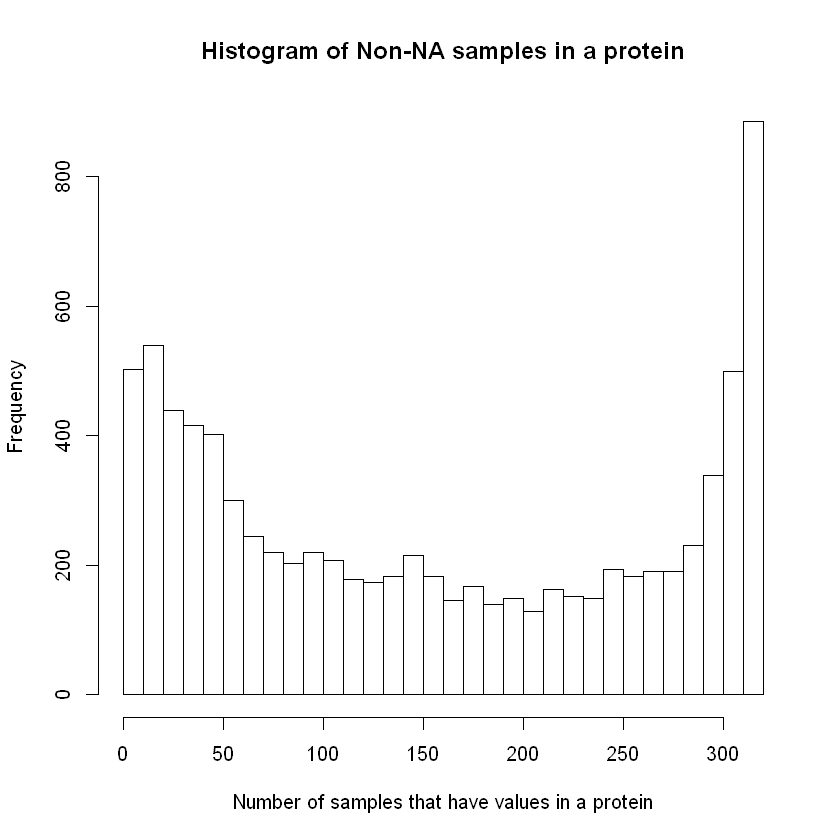

In [21]:
# For each protein group, how many samples have intensity values
hist(rowSums(!is.na(int_mtx)), breaks = 30,
     main = "Histogram of Non-NA samples in a protein",
     xlab = "Number of samples that have values in a protein")  

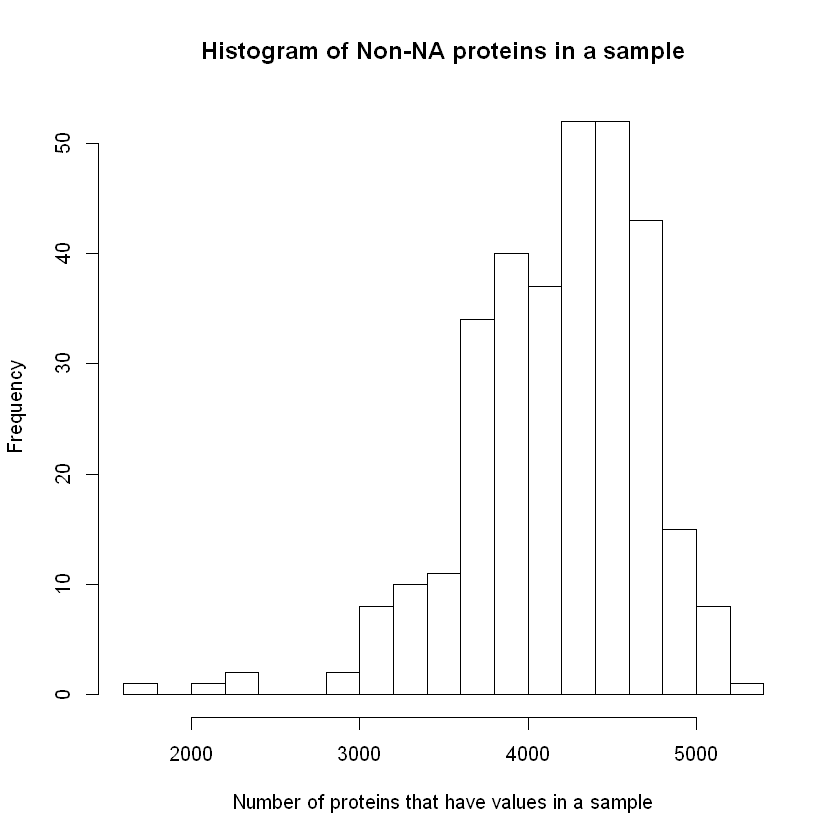

In [22]:
# For each sample, how many protein groups have intensity values
hist(colSums(!is.na(int_mtx)), breaks = 18,
     main = "Histogram of Non-NA proteins in a sample",
     xlab = "Number of proteins that have values in a sample")  

## Phosphorilation data

In [4]:
# # from /general_analysis/DataBaseUpload/NGS/Proteomics/bin/PhosphoProteomics_PreProccess.html
# # `Counts` are just 2 to the power of Intensity. This is for DE analysis where counts are needed
# phos <- read.csv("../proteomics/data/Protein_phos_data.csv")
# head(phos, 2)

id,ProteinGroupId,ProteinGroup,PhosLocation_Protein,SingleProtein,Sample,Intensity,Counts,ProteinGroupName,hgnc_symbol
1,A0A0B4J280,sp|A0A0B4J280|TVA40_HUMAN,S85,sp|A0A0B4J280|TVA40_HUMAN,CTG-0464,10.762,1737,TVA40_HUMAN,TRAV40
2,A0A0B4J280,sp|A0A0B4J280|TVA40_HUMAN,S85,sp|A0A0B4J280|TVA40_HUMAN,CTG-0502,12.949,7907,TVA40_HUMAN,TRAV40
3,A0A0B4J280,sp|A0A0B4J280|TVA40_HUMAN,S85,sp|A0A0B4J280|TVA40_HUMAN,CTG-0838,11.048,2117,TVA40_HUMAN,TRAV40
4,A0A0B4J280,sp|A0A0B4J280|TVA40_HUMAN,S85,sp|A0A0B4J280|TVA40_HUMAN,CTG-0852,9.974,1006,TVA40_HUMAN,TRAV40
5,A0A0B4J280,sp|A0A0B4J280|TVA40_HUMAN,S85,sp|A0A0B4J280|TVA40_HUMAN,CTG-1012,14.859,29717,TVA40_HUMAN,TRAV40
6,A0A0B4J280,sp|A0A0B4J280|TVA40_HUMAN,S85,sp|A0A0B4J280|TVA40_HUMAN,CTG-1329,10.467,1415,TVA40_HUMAN,TRAV40


In [49]:
# phos_int <- phos %>% 
#     select(c('ProteinGroup', 'Sample', 'Counts'))  %>% 
#     pivot_wider(names_from = Sample, values_from = Counts, values_fn = mean) %>% 
# #     pivot_wider(names_from = Sample, values_from = Intensity) %>% 
#     column_to_rownames('ProteinGroup')
# rm(phos)
# head(phos_int, 2)
# print(dim(phos_int))

,CTG-0464,CTG-0502,CTG-0838,CTG-0852,CTG-1012,CTG-1329,CTG-1352,CTG-1355,CTG-1360,CTG-1361,...,CTG-3799,CTG-2716,CTG-3064,CTG-3766,CTG-3793,CTG-3794,CTG-3796,CTG-3800,CTG-3801,CTG-3802
sp|A0A0B4J280|TVA40_HUMAN,1737,7907.00,2117.0,1006.0,29717,1415,9002.0,2095.00,9933,17487.00,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
sp|A0A0B4J2F2|SIK1B_HUMAN;sp|P57059|SIK1_HUMAN,85108,NA,24920.0,NA,19163,NA,28493.0,NA,34998,NA,...,44269.0,NA,NA,NA,NA,NA,NA,NA,NA,NA
sp|A0AV96|RBM47_HUMAN,100790,7691.00,213370.0,158486.0,13950,54956,60515.0,65764.00,NA,99886.00,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
sp|A0AVK6|E2F8_HUMAN,NA,NA,5379.0,47413.0,48983,NA,13654.0,NA,16613,NA,...,142175.5,57970,7097.0,74606.25,201621.5,117374.0,79821.33,484060.7,296613.3,161540.5
sp|A0AVT1|UBA6_HUMAN,7297,7186.00,10241.0,127135.0,102339,7221,14951.0,NA,5753,11075.00,...,15896.0,6992,17227.5,19014.00,27799.5,32364.5,37154.00,53121.0,21865.0,38245.0
sp|A0FGR8|ESYT2_HUMAN,45663,23800.67,106055.7,124390.3,17854,156255,118950.3,32271.33,17892,64168.33,...,59269.0,60893,4523.0,8164.00,13373.0,9548.0,33364.00,14125.0,NA,29553.0


[1] 5680  209


In [42]:
# x <- na.omit(phos_int)
# dim(x)

[1] 135 209

In [50]:
# # proportion of missin values
# sum(is.na(phos_int))/(dim(phos_int)[1] * dim(phos_int)[2])

[1] 0.5555218